In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from utils import load_data
from plotting import plot_image

In [2]:
data = load_data()
for key, value in data.items():
    print(f"{key}: {value.shape}")

# use only the first channel (ET)
ZB_train, ZB_val, ZB_test = data["ZB_train"][:, :, :, 0], data["ZB_val"][:, :, :, 0], data["ZB_test"][:, :, :, 0]


ZB_train: (102000, 18, 14, 3)
ZB_val: (34000, 18, 14, 3)
ZB_test: (34000, 18, 14, 3)
tt_lep_train: (14958, 18, 14, 3)
tt_lep_val: (4987, 18, 14, 3)
tt_lep_test: (4987, 18, 14, 3)


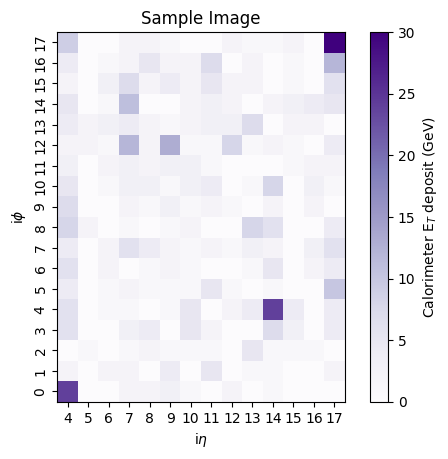

In [4]:
plot_image(ZB_train[42, :, :], "Sample Image")

In [5]:
# train a convolutional autoencoder only on inliers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, Activation, AveragePooling2D,
                                     UpSampling2D, Dense, Flatten, Reshape)


def get_teacher_model():
    inputs = Input(shape=(18, 14, 1), name="teacher_inputs_")
    x = Reshape((18, 14, 1), name="teacher_reshape")(inputs)
    x = Conv2D(8, (3, 3), strides=1, padding="same", name="teacher_conv2d_1")(x)
    x = Activation("relu", name="teacher_relu_1")(x)
    x = AveragePooling2D((2, 2), name="teacher_pool_1")(x)
    x = Conv2D(16, (3, 3), strides=1, padding="same", name="teacher_conv2d_2")(x)
    x = Activation("relu", name="teacher_relu_2")(x)
    x = Flatten(name="teacher_flatten")(x)
    x = Dense(32, activation="relu", name="teacher_latent")(x)
    x = Dense(9 * 7 * 16, name="teacher_dense")(x)
    x = Reshape((9, 7, 16), name="teacher_reshape2")(x)
    x = Activation("relu", name="teacher_relu_3")(x)
    x = Conv2D(16, (3, 3), strides=1, padding="same", name="teacher_conv2d_3")(x)
    x = Activation("relu", name="teacher_relu_4")(x)
    x = UpSampling2D((2, 2), name="teacher_upsampling")(x)
    x = Conv2D(8, (3, 3), strides=1, padding="same", name="teacher_conv2d_4")(x)
    x = Activation("relu", name="teacher_relu_5")(x)
    outputs = Conv2D(
        1,
        (3, 3),
        activation="relu",
        strides=1,
        padding="same",
        name="teacher_outputs",
    )(x)
    return Model(inputs, outputs, name="teacher")


In [7]:
# train on inliers only
teacher_model = get_teacher_model()

print(f"number of parameters: {teacher_model.count_params()}")
teacher_model.compile(optimizer='adam', loss='mse')
history = teacher_model.fit(
    ZB_train, ZB_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(ZB_val, ZB_val)
)

number of parameters: 70353
Epoch 1/10
797/797 [==============================] - 8s 9ms/step - loss: 4.0261 - val_loss: 3.6380
Epoch 2/10
797/797 [==============================] - 8s 10ms/step - loss: 3.5454 - val_loss: 3.4674
Epoch 3/10
797/797 [==============================] - 9s 11ms/step - loss: 3.4174 - val_loss: 3.3860
Epoch 4/10
797/797 [==============================] - 9s 11ms/step - loss: 3.3538 - val_loss: 3.3428
Epoch 5/10
797/797 [==============================] - 8s 11ms/step - loss: 3.3161 - val_loss: 3.3158
Epoch 6/10
797/797 [==============================] - 8s 10ms/step - loss: 3.2918 - val_loss: 3.2918
Epoch 7/10
797/797 [==============================] - 8s 10ms/step - loss: 3.2766 - val_loss: 3.2822
Epoch 8/10
797/797 [==============================] - 8s 10ms/step - loss: 3.2527 - val_loss: 3.2425
Epoch 9/10
797/797 [==============================] - 9s 11ms/step - loss: 3.2210 - val_loss: 3.2263
Epoch 10/10
797/797 [==============================] - 8s 10ms/s

In [8]:
X_signal = data["tt_lep_val"][:, :, :, 0]

preds_bg = teacher_model.predict(ZB_val).squeeze(-1)
mse_bg = np.mean(np.square(ZB_test - preds_bg), axis=(1, 2))

preds_sig = teacher_model.predict(X_signal).squeeze(-1)
mse_sig = np.mean(np.square(X_signal - preds_sig), axis=(1, 2))

156/156 [==============================] - 0s 1ms/step


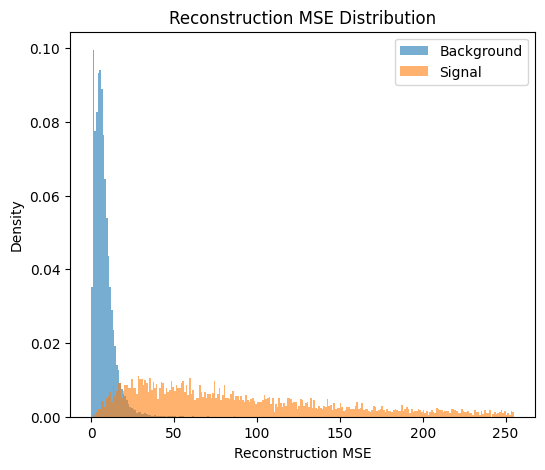

In [9]:
# plot MSE dists
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 5))
bins = range(256)
plt.hist(mse_bg, bins=bins, alpha=0.6, label='Background', density=True)
plt.hist(mse_sig, bins=bins, alpha=0.6, label='Signal', density=True)
plt.xlabel('Reconstruction MSE')
plt.ylabel('Density')
plt.title('Reconstruction MSE Distribution')
plt.legend()

In [10]:
# plot roc curve
from sklearn.metrics import roc_curve, auc
y_true = np.concatenate([np.zeros_like(mse_bg), np.ones_like(mse_sig)])
y_scores = np.concatenate([mse_bg, mse_sig])
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

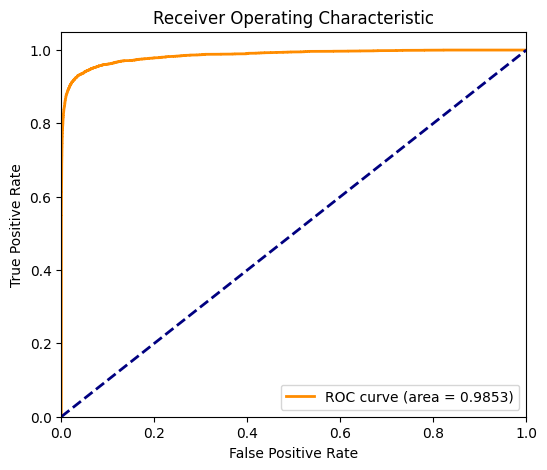

In [11]:
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()

In [ ]:
# make predictions and save to file

X_tt_lep_test = data["tt_lep_test"][:, :, :, 0]

X_test = np.concatenate([ZB_test, X_tt_lep_test], axis=0)

preds_test = teacher_model.predict(X_test).squeeze(-1)
mse_test = np.mean(np.square(X_test - preds_test), axis=(1, 2))

np.save('data/ZB_teacher_mse_test.npy', mse_test)